<a href="https://colab.research.google.com/github/aianshay/sales-time-series/blob/main/arima_box_jenkins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 63 kB 8.2 MB/s 
     |████████████████████████████████| 6.4 MB 14.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 5.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 


# Imports

In [4]:
import yfinance as yf

In [5]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [8]:
import pmdarima as pm

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [10]:
mpl.rcParams['figure.figsize'] = [10, 5]

# Loading data

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
sales = pd.read_csv('/content/drive/MyDrive/sales.csv')
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Selecionando vendas da categoria "PERSONAL CARE"

In [13]:
df = sales.query('store_nbr == 1 and family == "PERSONAL CARE"')
df.head()

,id,date,store_nbr,family,sales,onpromotion
25,25,2013-01-01,1,PERSONAL CARE,0.0,0
1807,1807,2013-01-02,1,PERSONAL CARE,194.0,0
3589,3589,2013-01-03,1,PERSONAL CARE,153.0,0
5371,5371,2013-01-04,1,PERSONAL CARE,88.0,0
7153,7153,2013-01-05,1,PERSONAL CARE,141.0,0


Removendo as coluna 'id', 'store_nbr', 'family' e 'onpromotion'

In [14]:
df_sales = df.drop(columns=['id', 'store_nbr', 'family', 'onpromotion'])
df_sales.head()

,date,sales
25,2013-01-01,0.0
1807,2013-01-02,194.0
3589,2013-01-03,153.0
5371,2013-01-04,88.0
7153,2013-01-05,141.0


Plotando a série temporal

<Figure size 720x36000 with 0 Axes>

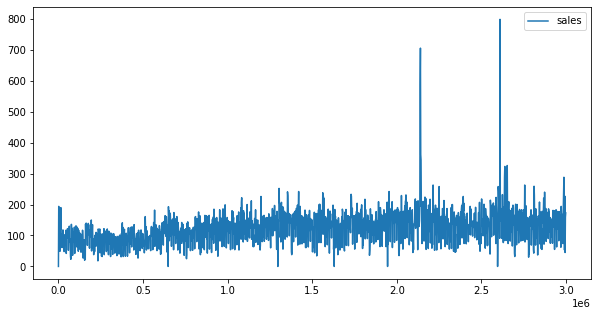

In [15]:
plt.figure(figsize=(10,500))

df_sales.plot()

Convertendo a data para datetime

In [16]:
df_sales['date'] = pd.to_datetime(df_sales['date'])

In [17]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1684 entries, 25 to 2999131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1684 non-null   datetime64[ns]
 1   sales   1684 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


Verificamos que o dataset não possui dados nulos

In [18]:
df_sales.isna().sum()

date     0
sales    0
dtype: int64

# Análise de Séries Temporais (TSA)

Decomposição da séries: tendência, sazonalidade, resíduo

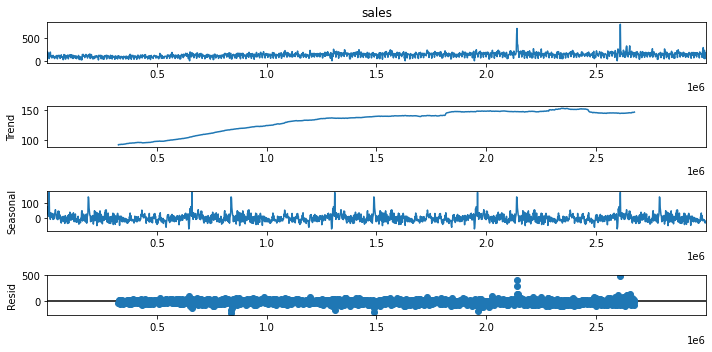

In [19]:
sales_decomp = tsa.seasonal_decompose(df_sales['sales'], period=365)
sales_decomp.plot();

### Stationarity

Estacionariedade: média e desvio constante ao longo do tempo

Média móvel de 7 dias

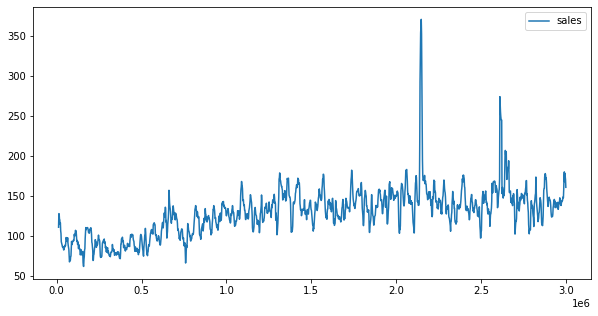

In [20]:
df_sales.rolling(7).mean().plot()

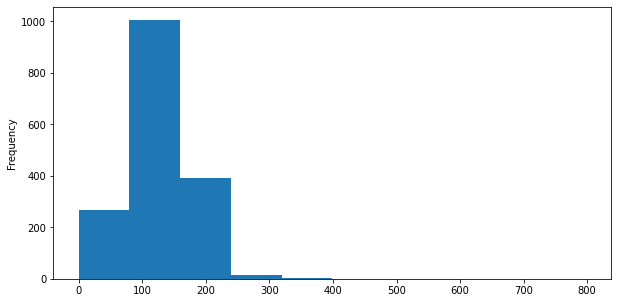

In [21]:
df_sales['sales'].plot.hist()

Teste de estacionariedade

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

In [22]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df_sales['sales'], regression='ct')
print(pvalue)
print(lags)

4.1523879439193943e-07
22


In [23]:
4.1523879439193943e-07 < 0.01

True

O teste Dickey-Fuller (ADF) rejeita a hipótese nula de não estacionaridade usando 22 lags, o p-valor foi inferior 1%, portanto há evidência estatística de que a série diferenciada é estacionária.

### Differentiation


* Série: distância percorrida ao longo do tempo
* Diferenciação de 1a ordem = velocidade (diferença entre as distâncias)
* Diferenciação de 2a ordem = aceleração (diferença entre as velocidades)
* Diferenciação de 3a ordem = arrancada (diferença entre as acelerações)


##### Diferentiation 1st order (d)

In [24]:
diff = df_sales['sales'].diff().dropna()

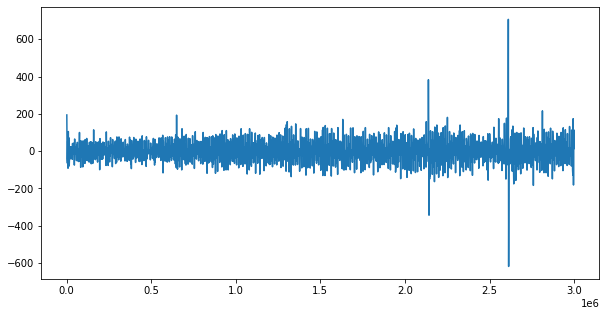

In [25]:
diff.plot();

Após a diferenciação, a série passa a ter um comportamento estacionário

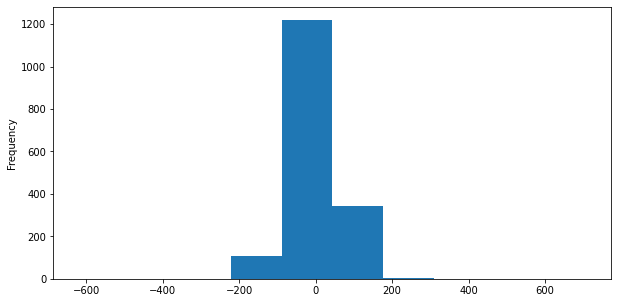

In [26]:
diff.plot.hist()

Histograma após a diferenciação, aproxima-se de uma distribuição normal 

In [27]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(diff, regression='ct')
print(pvalue)
print(lags)

9.228148355211533e-20
25


### Autocorrelation

A correlation of a variable with itself at different times
is known as autocorrelation or serial correlation.

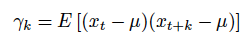

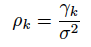

Série com lag (atraso) = 1

In [28]:
from scipy.stats import pearsonr

In [29]:
df_sales['sales'].shift(1)

25           NaN
1807         0.0
3589       194.0
5371       153.0
7153        88.0
           ...  
2992003    183.0
2993785     53.0
2995567    227.0
2997349     45.0
2999131    159.0
Name: sales, Length: 1684, dtype: float64

autocorrelação com lag 1

In [30]:
df_sales.corrwith(df_sales['sales'].shift(1))

sales    0.278298
dtype: float64

Gráfico de autocorrelação da série com 35 lags

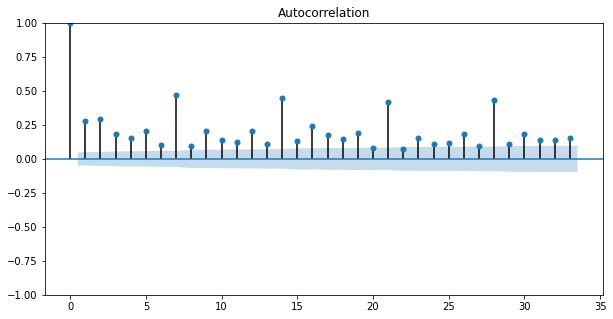

In [31]:
plot_acf(df_sales['sales']);

In [32]:
df_sales.head()

,date,sales
25,2013-01-01,0.0
1807,2013-01-02,194.0
3589,2013-01-03,153.0
5371,2013-01-04,88.0
7153,2013-01-05,141.0


In [33]:
df_sales.index = df_sales.date
df_sales = df_sales.drop(columns=['date'])
df_sales.head()

,sales
date,
2013-01-01,0.0
2013-01-02,194.0
2013-01-03,153.0
2013-01-04,88.0
2013-01-05,141.0


In [34]:
df_sales.corrwith(df_sales.shift(1))

sales    0.278298
dtype: float64

Gráfico de autocorrelação da série diferenciada com 35 lags

In [35]:
diff_sales = df_sales.diff().dropna()
diff_sales

,sales
date,
2013-01-02,194.0
2013-01-03,-41.0
2013-01-04,-65.0
2013-01-05,53.0
2013-01-06,-92.0
...,...
2017-08-11,-130.0
2017-08-12,174.0
2017-08-13,-182.0


In [36]:
diff_sales.corrwith(diff_sales)

sales    1.0
dtype: float64

In [37]:
diff_sales.corrwith(diff_sales.shift(1))

sales   -0.507911
dtype: float64

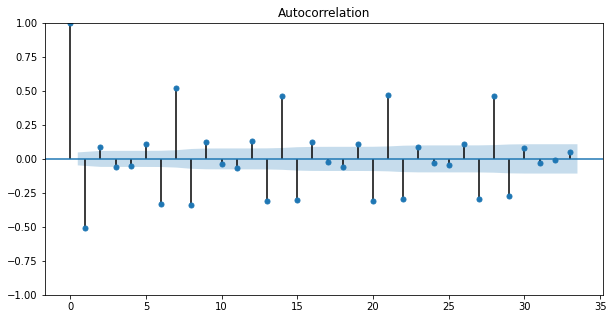

In [38]:
plot_acf(diff_sales);

### Partial Correlation

The partial autocorrelation at lag k is the correlation that
results after removing the effect of any correlations due to the terms at shorter
lags.

Gráfico de autocorrelação parcial da série com 35 lags

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


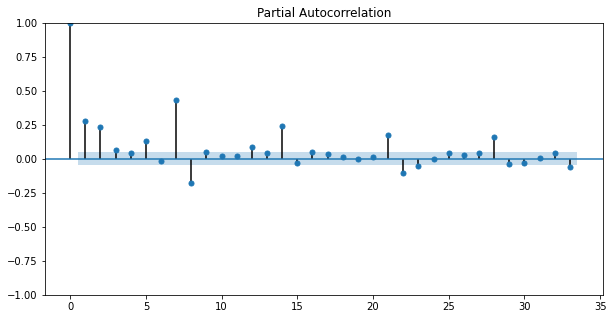

In [39]:
plot_pacf(df_sales);

A autocorrelação parcial mostra que poucos lags apresentação correlação com significância estatística, ao contrário do que autocorrelação faz crer.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


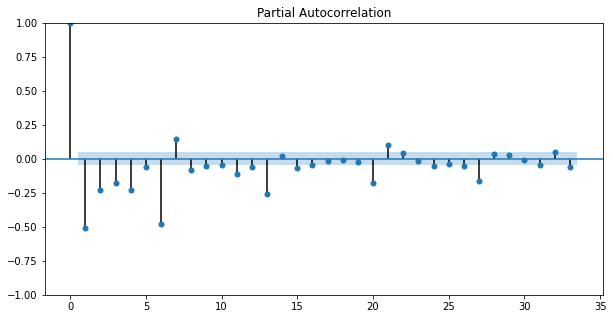

In [40]:
plot_pacf(diff_sales);

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

# Models

### Separação dos dados
* 75% treino
* 25% teste

In [41]:
sales_train = df_sales.iloc[:int(len(df_sales) * 0.75)]
sales_test = df_sales.iloc[int(len(df_sales) * 0.75):]

In [42]:
sales_test

,sales
date,
2016-06-20,258.0
2016-06-21,116.0
2016-06-22,153.0
2016-06-23,154.0
2016-06-24,111.0
...,...
2017-08-11,53.0
2017-08-12,227.0
2017-08-13,45.0


In [43]:
sales_train_diff = df_sales.iloc[:int(len(diff_sales) * 0.75)]
sales_test_diff = df_sales.iloc[int(len(diff_sales) * 0.75):]

In [44]:
sales_test_diff

,sales
date,
2016-06-19,77.0
2016-06-20,258.0
2016-06-21,116.0
2016-06-22,153.0
2016-06-23,154.0
...,...
2017-08-11,53.0
2017-08-12,227.0
2017-08-13,45.0


### AR model (p)

Definição e treino do modelo AR com 3 lags (Autocorrelação)

In [45]:
model_ar =  ARIMA(sales_train, order=(3,0,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [46]:
model_ar2 = model_ar.fit()
model_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1263
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -6582.891
Date:                Mon, 18 Apr 2022   AIC                          13175.782
Time:                        20:29:04   BIC                          13201.488
Sample:                             0   HQIC                         13185.441
                               - 1263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.8052      2.989     41.415      0.000     117.946     129.664
ar.L1          0.2349      0.014     16.356      0.000       0.207       0.263
ar.L2          0.2669      0.032      8.413      0.000       0.205       0.329
ar.L3          0.0546      0.028      1.958      0.050   -6.15e-05       0.109
sigma2      1970.6874     40.643     48.488      0.000    1891.029    2050.346
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12177.11
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.56   Skew:                             1.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Análise dos resíduos
* Não normalidade da distribuição dos resíduos
* Correlograma apresenta 3 lags com significância estatística

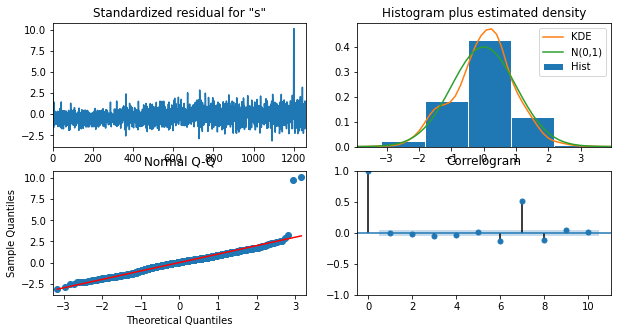

In [47]:
model_ar2.plot_diagnostics();

In [48]:
model_ar3 = model_ar2.apply(sales_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [49]:
model_ar3.predict()

date
2016-06-20    123.805246
2016-06-21    170.483463
2016-06-22    159.503000
2016-06-23    135.901929
2016-06-24    138.265962
                 ...    
2017-08-11    187.823372
2017-08-12    131.928101
2017-08-13    132.380009
2017-08-14    128.972456
2017-08-15    116.669211
Name: predicted_mean, Length: 421, dtype: float64

In [50]:
pd.concat([model_ar3.predict(), sales_test],axis=1)

,predicted_mean,sales
date,,
2016-06-20,123.805246,258.0
2016-06-21,170.483463,116.0
2016-06-22,159.503000,153.0
2016-06-23,135.901929,154.0
2016-06-24,138.265962,111.0
...,...,...
2017-08-11,187.823372,53.0
2017-08-12,131.928101,227.0
2017-08-13,132.380009,45.0


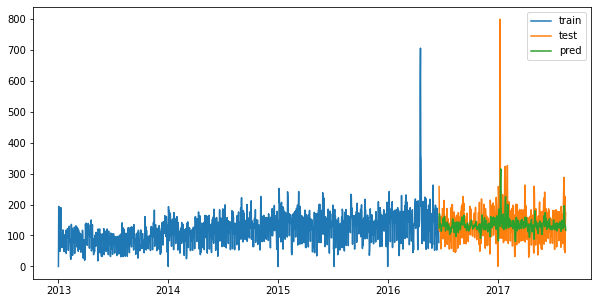

In [51]:
fig, ax = plt.subplots()
ax.plot(sales_train, label='train')
ax.plot(sales_test, label='test')
ax.plot(model_ar3.predict(), label='pred')

plt.legend()

Análise das métricas de erro do modelo
* R2: mais próximo de 1 é melhor
* MSE: mais próximo de 0 é melhor
* MAE: mais próximo de 0 é melhor

In [52]:
print('Sales - AR model Results')
print('mse', mean_squared_error(model_ar3.predict(), sales_test))
print('mae', mean_absolute_error(model_ar3.predict(), sales_test))
print('mape', mean_absolute_percentage_error(model_ar3.predict(), sales_test))

Sales - AR model Results
mse 3667.536883772577
mae 40.639585586942125
mape 0.31027674543928846


Definição e treino do modelo AR com 4 lags (Autocorrelação diferenciada)

In [53]:
model_ar_diff =  ARIMA(sales_train, order=(4,0,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [54]:
model_ar_diff2 = model_ar_diff.fit()
model_ar_diff2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1263
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -6582.421
Date:                Mon, 18 Apr 2022   AIC                          13176.842
Time:                        20:29:06   BIC                          13207.690
Sample:                             0   HQIC                         13188.433
                               - 1263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.8056      3.157     39.212      0.000     117.617     129.994
ar.L1          0.2335      0.014     16.260      0.000       0.205       0.262
ar.L2          0.2595      0.033      7.863      0.000       0.195       0.324
ar.L3          0.0480      0.031      1.567      0.117      -0.012       0.108
ar.L4          0.0274      0.032      0.854      0.393      -0.035       0.090
sigma2      1969.1977     41.532     47.414      0.000    1887.796    2050.599
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12406.34
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Análise dos resíduos

* Não normalidade da distribuição dos resíduos
* Correlograma apresenta 3 lags com significância estatística

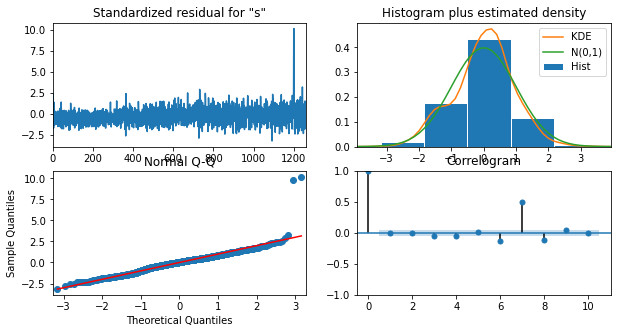

In [55]:
model_ar_diff2.plot_diagnostics();

In [56]:
model_ar_diff3 = model_ar_diff2.apply(sales_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


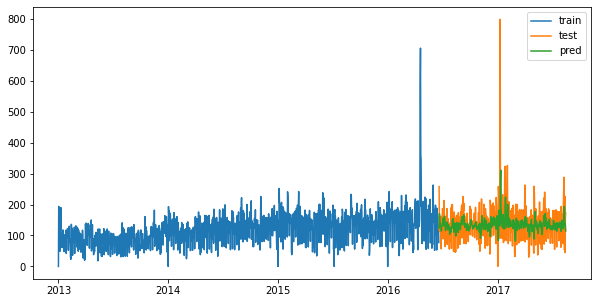

In [57]:
fig, ax = plt.subplots()
ax.plot(sales_train, label='train')
ax.plot(sales_test, label='test')
ax.plot(model_ar_diff3.predict(), label='pred')

plt.legend()

In [58]:
print('Sales - AR model Results')
print('mse', mean_squared_error(model_ar3.predict(), sales_test))
print('mae', mean_absolute_error(model_ar3.predict(), sales_test))
print('mape', mean_absolute_percentage_error(model_ar3.predict(), sales_test))

Sales - AR model Results
mse 3667.536883772577
mae 40.639585586942125
mape 0.31027674543928846


In [59]:
print('Sales - AR model Results')
print('mse', mean_squared_error(model_ar_diff3.predict(), sales_test))
print('mae', mean_absolute_error(model_ar_diff3.predict(), sales_test))
print('mape', mean_absolute_percentage_error(model_ar_diff3.predict(), sales_test))

Sales - AR model Results
mse 3653.7445186849277
mae 40.51548829277939
mape 0.3079990902915597


Considerando o mape o modelo usando a diferenciação foi melhor

In [60]:
results = {}

In [61]:
print('AR model Results')
results['AR'] = {'mse': mean_squared_error(model_ar_diff3.predict(), sales_test),
                 'mae': mean_absolute_error(model_ar_diff3.predict(), sales_test),
                 'mape': mean_absolute_percentage_error(model_ar_diff3.predict(), sales_test)}
results['AR']

AR model Results


{'mae': 40.51548829277939,
 'mape': 0.3079990902915597,
 'mse': 3653.7445186849277}

Seleção da melhor ordem para o modelo AR

In [62]:
from statsmodels.tsa.stattools import arma_order_select_ic

In [63]:
ar_order_selection = arma_order_select_ic(df_sales, max_ar=10, max_ma=0)

In [64]:
ar_order_selection

{'bic':                0
 0   18120.130117
 1   17991.887620
 2   17906.809182
 3   17907.547764
 4   17911.803184
 5   17890.677378
 6   17897.417687
 7   17546.010619
 8   17497.560996
 9   17500.934651
 10  17507.715871, 'bic_min_order': (8, 0)}

### MA Model (q)

Definição e treino do modelo média móvel com 7 lags

In [65]:
model_ma = ARIMA(sales_train.values, order=(0,0,7))

In [66]:
model_ma2 = model_ma.fit()

In [67]:
model_ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1263
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -6438.690
Date:                Mon, 18 Apr 2022   AIC                          12895.380
Time:                        20:29:31   BIC                          12941.651
Sample:                             0   HQIC                         12912.766
                               - 1263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.8058      2.845     43.524      0.000     118.231     129.381
ma.L1          0.3440      0.015     22.492      0.000       0.314       0.374
ma.L2          0.2826      0.025     11.443      0.000       0.234       0.331
ma.L3          0.1607      0.026      6.206      0.000       0.110       0.211
ma.L4          0.1040      0.027      3.871      0.000       0.051       0.157
ma.L5          0.1257      0.027      4.730      0.000       0.074       0.178
ma.L6         -0.0521      0.024     -2.170      0.030      -0.099      -0.005
ma.L7          0.3688      0.024     15.254      0.000       0.321       0.416
sigma2      1566.6557     34.657     45.204      0.000    1498.729    1634.582
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):             14229.32
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.44   Skew:                             1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Análise dos resíduos
* Não normalidade da distribuição
* Correlograma apresenta 2 lags com significância estatística

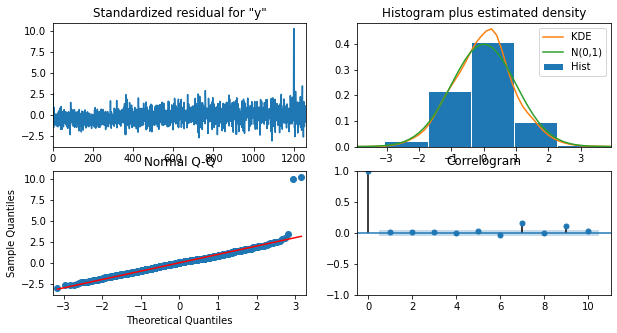

In [68]:
model_ma2.plot_diagnostics();

In [69]:
model_ma3 = model_ma2.apply(sales_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


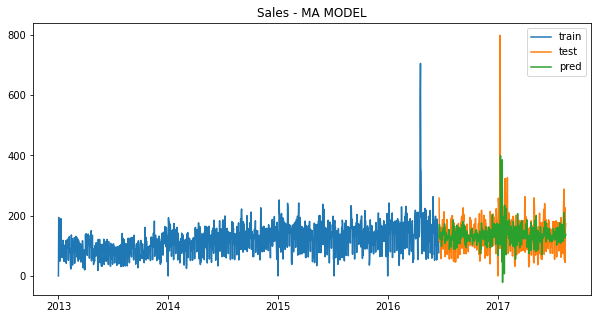

In [70]:
fig, ax = plt.subplots()
ax.plot(sales_train, label='train')
ax.plot(sales_test, label='test')
ax.plot(model_ma3.predict(), label='pred')

plt.title('Sales - MA MODEL')
plt.legend()

Definição e treino do modelo média móvel com 2 lag

In [71]:
model_ma_diff = ARIMA(sales_train.values, order=(0,0,2))

In [72]:
model_ma_diff2 = model_ma_diff.fit()

In [73]:
model_ma_diff2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1263
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -6612.682
Date:                Mon, 18 Apr 2022   AIC                          13233.363
Time:                        20:29:35   BIC                          13253.928
Sample:                             0   HQIC                         13241.090
                               - 1263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.8037      2.046     60.523      0.000     119.794     127.813
ma.L1          0.2432      0.014     17.221      0.000       0.216       0.271
ma.L2          0.2549      0.027      9.333      0.000       0.201       0.308
sigma2      2066.0319     43.199     47.826      0.000    1981.364    2150.700
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):             10748.59
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Análise dos resíduos

* Não normalidade da distribuição
* Correlograma: vários lags apresenta correlação significante

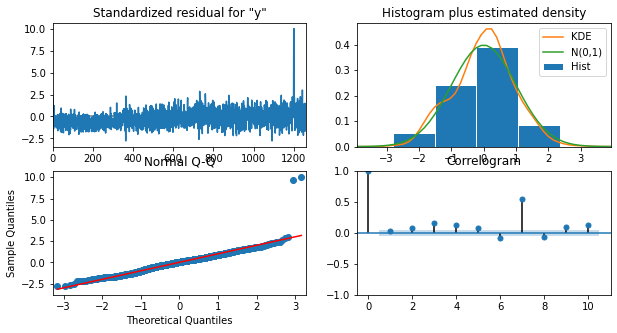

In [74]:
model_ma_diff2.plot_diagnostics();

In [75]:
model_ma_diff3 = model_ma_diff2.apply(sales_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


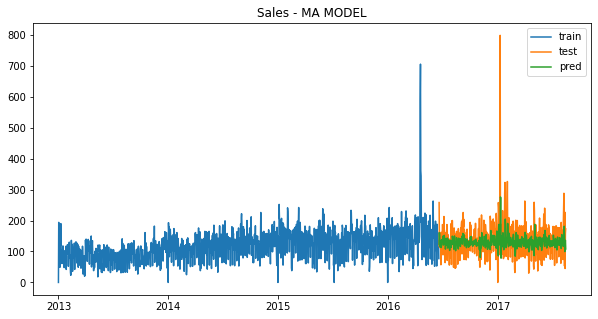

In [76]:
fig, ax = plt.subplots()
ax.plot(sales_train, label='train')
ax.plot(sales_test, label='test')
ax.plot(model_ma_diff3.predict(), label='pred')

plt.title('Sales - MA MODEL')
plt.legend()

Comparação dos resultados

In [77]:
print('Sales - AR model Results')
print('mse', mean_squared_error(model_ma_diff3.predict(), sales_test))
print('mae', mean_absolute_error(model_ma_diff3.predict(), sales_test))
print('mape', mean_absolute_percentage_error(model_ma_diff3.predict(), sales_test))

Sales - AR model Results
mse 3691.73875697976
mae 41.367258530389975
mape 0.3270741528086659


In [78]:
print('MA model Results')
results['MA'] = {'mse': mean_squared_error(model_ma3.predict(), sales_test), 
                 'mae': mean_absolute_error(model_ma3.predict(), sales_test),
                 'mape': mean_absolute_percentage_error(model_ma3.predict(), sales_test)}
results['MA']

MA model Results


{'mae': 39.48299215740378,
 'mape': 0.37576869328866547,
 'mse': 3703.7012489308104}

### Arima Model

Treino do modelo ARIMA (3,1,7).

In [79]:
model_arima = ARIMA(sales_train, order=(3,1,7)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [80]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1263
Model:                 ARIMA(3, 1, 7)   Log Likelihood               -6395.423
Date:                Mon, 18 Apr 2022   AIC                          12812.847
Time:                        20:29:47   BIC                          12869.392
Sample:                             0   HQIC                         12834.094
                               - 1263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9046      0.104     -8.700      0.000      -1.108      -0.701
ar.L2         -0.5664      0.141     -4.011      0.000      -0.843      -0.290
ar.L3         -0.1984      0.092     -2.146      0.032      -0.380      -0.017
ma.L1          0.2031      0.106      1.914      0.056      -0.005       0.411
ma.L2         -0.1342      0.081     -1.659      0.097      -0.293       0.024
ma.L3         -0.4066      0.050     -8.196      0.000      -0.504      -0.309
ma.L4         -0.3979      0.072     -5.501      0.000      -0.540      -0.256
ma.L5         -0.1860      0.042     -4.479      0.000      -0.267      -0.105
ma.L6         -0.2634      0.031     -8.435      0.000      -0.325      -0.202
ma.L7          0.2724      0.041      6.693      0.000       0.193       0.352
sigma2      1472.0489     31.352     46.953      0.000    1410.601    1533.497
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             20289.87
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.78   Skew:                             1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Análise dos resíduos

* Não normalidade da distribuição
* Correlograma apresenta 1 lags com significância estatística

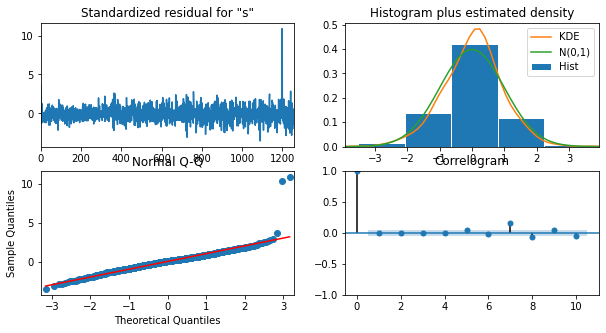

In [81]:
model_arima.plot_diagnostics();

In [82]:
model_arima2 = model_arima.apply(sales_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


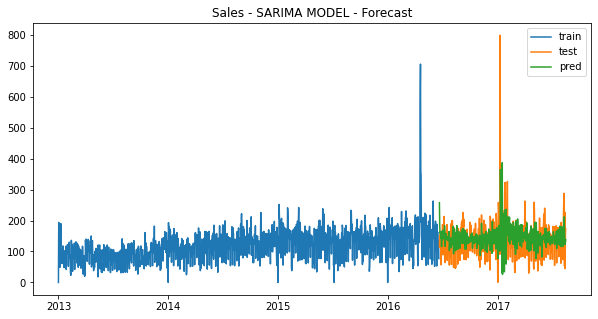

In [83]:
fig, ax = plt.subplots()
ax.plot(sales_train, label='train')
ax.plot(sales_test.iloc[1:], label='test')
ax.plot(model_arima2.predict().iloc[1:], label='pred')

plt.title('Sales - SARIMA MODEL - Forecast')
plt.legend()

A previsão mostra que o modelo está com o comportamento random walk (passeio aleatório). Ele usa o dado mais recente como previsão, e não é capaz de extrair um padrão (equação) dos dados, então sempre está "atrasado" em relação ao comportamento real dos dados.



In [84]:
print('ARIMA model Results')
print('mse', mean_squared_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:]))
print('mae', mean_absolute_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:]))
print('mape', mean_absolute_percentage_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:]))

ARIMA model Results
mse 3585.8418796923343
mae 39.06498010023072
mape 0.3027310957544633


Treino do modelo ARIMA (4,1,2).

In [85]:
model_arima_diff = ARIMA(sales_train, order=(4,1,2)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/l

In [86]:
model_arima_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1263
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -6459.225
Date:                Mon, 18 Apr 2022   AIC                          12932.449
Time:                        20:29:51   BIC                          12968.432
Sample:                             0   HQIC                         12945.970
                               - 1263                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6541      0.031    -21.019      0.000      -0.715      -0.593
ar.L2          0.3003      0.028     10.780      0.000       0.246       0.355
ar.L3          0.1069      0.031      3.476      0.001       0.047       0.167
ar.L4         -0.2241      0.033     -6.830      0.000      -0.288      -0.160
ma.L1         -0.1000      0.027     -3.673      0.000      -0.153      -0.047
ma.L2         -0.8518      0.027    -31.355      0.000      -0.905      -0.799
sigma2      1629.1541     33.818     48.175      0.000    1562.873    1695.435
===================================================================================
Ljung-Box (L1) (Q):                   1.72   Jarque-Bera (JB):             22539.21
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                             1.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Análise dos resíduos

* Não normalidade da distribuição
* Correlograma apresenta vários lags com significância estatística

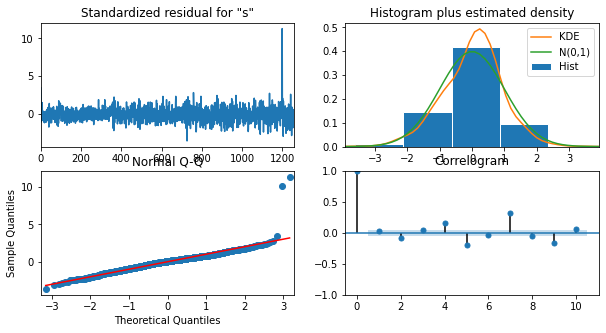

In [87]:
model_arima_diff.plot_diagnostics();

In [88]:
model_arima_diff2 = model_arima_diff.apply(sales_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


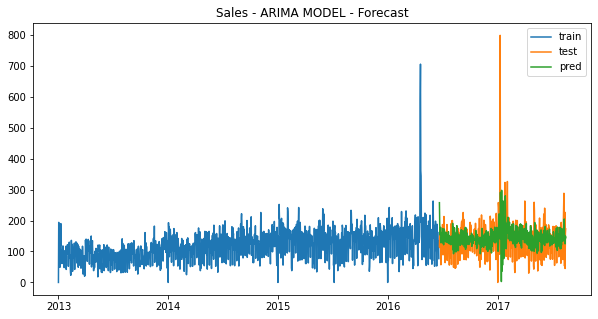

In [89]:
fig, ax = plt.subplots()
ax.plot(sales_train, label='train')
ax.plot(sales_test.iloc[1:], label='test')
ax.plot(model_arima_diff2.predict().iloc[1:], label='pred')

plt.title('Sales - ARIMA MODEL - Forecast')
plt.legend()

In [90]:
print('ARIMA model Results')
print('mse', mean_squared_error(model_arima_diff2.predict().iloc[1:], sales_test.iloc[1:]))
print('mae', mean_absolute_error(model_arima_diff2.predict().iloc[1:], sales_test.iloc[1:]))
print('mape', mean_absolute_percentage_error(model_arima_diff2.predict().iloc[1:], sales_test.iloc[1:]))

ARIMA model Results
mse 3668.349017099938
mae 41.1418256129393
mape 0.41951799327116895


In [91]:
print('ARIMA model Results')
print('mse', mean_squared_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:]))
print('mae', mean_absolute_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:]))
print('mape', mean_absolute_percentage_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:]))

ARIMA model Results
mse 3585.8418796923343
mae 39.06498010023072
mape 0.3027310957544633


In [92]:
print('ARIMA model Results')

results['ARIMA'] = {'mse': mean_squared_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:]),
                      'mae': mean_absolute_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:]),
                      'mape': mean_absolute_percentage_error(model_arima2.predict().iloc[1:], sales_test.iloc[1:])}
results['ARIMA']


ARIMA model Results


{'mae': 39.06498010023072,
 'mape': 0.3027310957544633,
 'mse': 3585.8418796923343}

Vamos verificar como será a previsão do modelo se não atualizarmos os dados de entrada com os dados conhecidos a medida avançamos na série, ou seja, usando um multi step recursivo, em que as previsões passadas alimentam as previsões futuras, usando o parâmetro <u>dynamic</u>

### Auto arima (p, d, q)


Modelo ARIMA
* p = AR
* d = diferenciação
* q = MA

Auto arima faz uma busca em grade pela melhor ordem para o modelo:
* p = [0, 10]
* d = [0, 2]
* q = [0, 10]

In [93]:
model_auto_arima = pm.auto_arima(sales_train, max_ar=10, max_ma=10, max_d=2, seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13760.292, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13377.162, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13126.578, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13758.293, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13103.353, Time=1.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13073.359, Time=1.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13111.407, Time=1.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13072.535, Time=1.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12919.112, Time=3.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.97 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Ti

In [94]:
model_auto_arima2 = ARIMA(sales_train, order=(5,1,5)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Análise dos resíduos
* Normalidade da distribuição
* Correlograma apresenta 2 lags com significância estatística

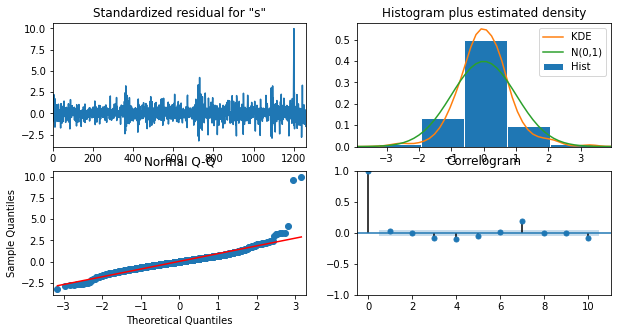

In [95]:
model_auto_arima2.plot_diagnostics();

Substituição dos dados de treino pelo de teste para realizar as previsões de teste.

In [96]:
model_auto_arima3 = model_auto_arima2.apply(sales_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


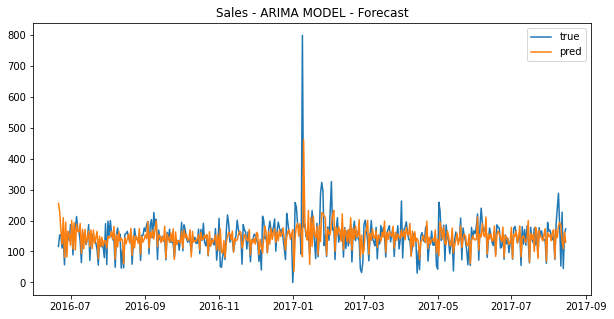

In [97]:
fig, ax = plt.subplots()
ax.plot(sales_test.iloc[1:], label='true')
ax.plot(model_auto_arima3.predict().iloc[1:], label='pred')

plt.title('Sales - ARIMA MODEL - Forecast')
plt.legend()

In [98]:
print('ARIMA model Results')
results['Auto ARIMA'] = {'mse': mean_squared_error(model_auto_arima3.predict(), sales_test), 
                         'mae': mean_absolute_error(model_auto_arima3.predict(), sales_test),
                         'mape': mean_absolute_percentage_error(model_auto_arima3.predict(), sales_test)}
results['Auto ARIMA']

ARIMA model Results


{'mae': 32.58715916841393,
 'mape': 2759925662379069.0,
 'mse': 3246.7698134057346}

### Comparação dos resultados

In [99]:
pd.DataFrame(results)

,AR,MA,ARIMA,Auto ARIMA
mse,3653.744519,3703.701249,3585.841880,3.246770e+03
mae,40.515488,39.482992,39.064980,3.258716e+01
mape,0.307999,0.375769,0.302731,2.759926e+15


### Best Model

MA com 7 lags

Predição dados de teste

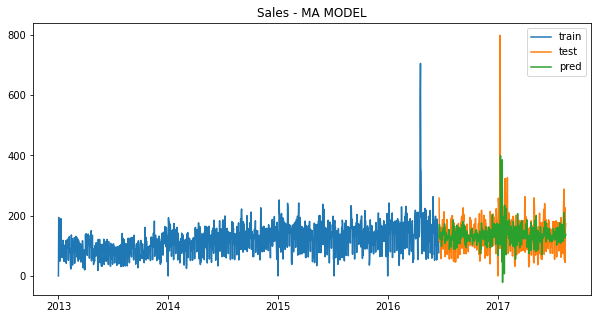

In [100]:
fig, ax = plt.subplots()
ax.plot(sales_train, label='train')
ax.plot(sales_test, label='test')
ax.plot(model_ma3.predict(), label='pred')

plt.title('Sales - MA MODEL')
plt.legend()